# Univariate fMRI analysis -  yes v. no response activations

Data from HCP social task (Barch et al, 2013, van Essen et al, 2013 - NeuroImage)

- This script has the code I used for the fMRI analyses mentioned in the OHBM abstract (improved now)

- Here each movie was modelled separately using two linear models: BOLD = f(stimPresence), stimPresence &isin; {0,1} and BOLD = f(normalized TR#). I refer to these as the block and the slope regressor, resp.
- The resultant beta values for each sub, node and movie, can be used to compare brain activity between subject groups who responded 'yes'/'social' and 'no'/'nonsocial' using button presses in the scanner

- I did this comparison using
(1) unpaired t-tests for each node of the most ambiguous movie (random mechanical) and plotted the T-scores on a brain map thresholded at p =.05 (fdr corr. at .05), and 
(2) selecting only common subjects and performing paired t-tests across subjects for movies with comparable decision times (from a separate online expt). also thresholded and fdr corrected like before

- Ignore the section 'extra' in the end

Rekha Varrier, 2021-22

In [4]:
# import packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path
from datetime import datetime

# TO DO - REMOVE THE UNNECESSARY LIBRARY IMPORTS

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


Now let's get working on the dataset. First we need to extract the data per trial + fixations

In [5]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [6]:
# order of movies - constant across subjects. useful to display while running analyses
vid_names = {}
movie_types = [1,0,0,1,0,1,1,0,1,0] # based on general responses. 1 is for social, 0 for nonsocial
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_joined

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [7]:
#suff= ' '
suff = '_corrected'

In [8]:
# timepts_indiv_movie = file with TRs within run to be selected for each movie (including a few fixation TRs at the start and end),
# vid_start_rel_tr = the TR at which the movie begins within each timecourse snippet
# details in 1_1_create_regressors.ipynb
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
l_task = 28 # lenght of experient = 20 seconds or 28 TRs
tcs_run_z = np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm{suff}.npy'))  # movie wise timecourses from tr-14:tr+14
tcs_run_z.shape

(1049, 268, 56, 10)

In [9]:
tcs_trial_z = np.load(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm{suff}.npy'))  # movie wise timecourses from tr-14:tr+14
tcs_trial_z.shape

(1049, 268, 56, 10)

In [11]:
dir_name_beh = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/data/'
beh_data = pd.read_csv(dir_name_beh + 'hcp_social_behav_for_ddm_stim-coding_corrected.csv')
beh_data.loc[beh_data['subj_idx']==subID[1],:]

,subj_idx,stim,movie,rt,response
1909,553344,Mental,Scaring.AVI,1.096,1
1910,553344,Mental,SEDUCING-B.AVI,0.792,1
1911,553344,Random,STAR-A.AVI,0.731,0
1912,553344,Mental,SURPRISING-B.AVI,1.536,1
1913,553344,Random,TENNIS-A.AVI,0.864,0
4807,553344,Mental,COAXING-B.AVI,1.066,1
4808,553344,Random,BILLIARD-A.AVI,1.035,0
4809,553344,Random,DRIFTING-A.AVI,0.984,0
4810,553344,Mental,Fishing.AVI,0.822,1
4811,553344,Random,Random mechanical.AVI,0.880,0


# A la traditional-GLM analysis: BOLD timecourse = f(movie)

- The GLM is done at the trial level i.e., each timecourse spans from t-14 to t+28 +14 (if t is the onset TR, except movie 1)

- first analysis is simple - for each movie, node and subject, we create a block regressor including the movie time windows + fixations before and after it. Then we fit the equation: BOLD = b0+b1*stimPresence, and compare b1 across subjects responses etc. (stimPresence = 1 during the video block and 0 otherwise)
- along with that, a parallel analysis uses a slope regressor indicating changes across time: BOLD = b0+b1*stimTime


### Defining the HRF

Text(0.5, 0, 'Time')

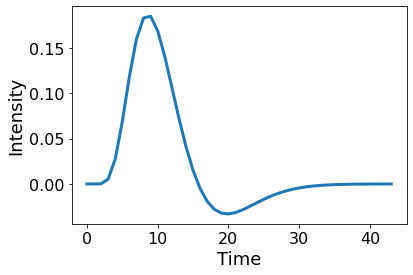

In [12]:
#defining the hrf
from nltools.external import glover_hrf

tr = .72
#hrf function
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

## Creating the convolved block and slope regressors

In [13]:
# function needed for the GLM
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool
from joblib import cpu_count

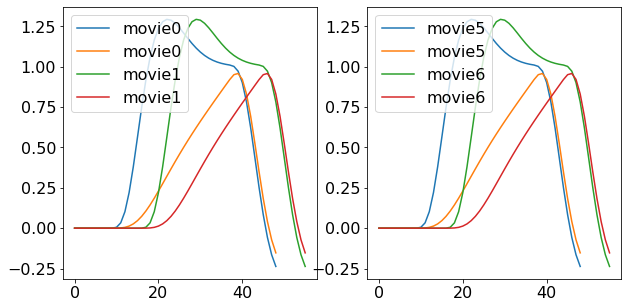

In [14]:
# illustrating the convolution
plt.figure(1,figsize = (10,5))
for vid_no in [0,1,5,6]:
    reg_block = np.zeros((len(timepts_indiv_movie[vid_no]),))
    reg_slope = np.zeros_like(reg_block)

    inds_block = np.arange(vid_start_rel_tr[vid_no]+1,vid_start_rel_tr[vid_no]+l_task+1)
    reg_block[inds_block] = 1 
    reg_block = np.convolve(reg_block, hrf)[:len(reg_block)]

    inds_slope = np.arange(vid_start_rel_tr[vid_no],vid_start_rel_tr[vid_no]+l_task+1)
    reg_slope[inds_slope] = np.linspace(0,1,len(inds_slope))
    reg_slope = np.convolve(reg_slope, hrf)[:len(reg_slope)]
    
    if vid_no < 5:
        plt.subplot(1,2,1)
    else:
        plt.subplot(1,2,2)

    if vid_no%5==0:
        plt.plot(reg_block,label = f'movie{vid_no}')
        plt.plot(reg_slope,label = f'movie{vid_no}')
    if vid_no%5!=0:
        plt.plot(reg_block,label = f'movie{vid_no}')
        plt.plot(reg_slope,label = f'movie{vid_no}')
    plt.legend()

### GLM

- Next,we perform a linear regression for each subject, movie (trial) and node. This takes about 3-4mins, so skip to quickly load data stored previously


In [15]:
vid_start_rel_tr

array([6, 13, 13, 13, 13, 6, 13, 13, 13, 13], dtype=object)

In [42]:
# functions that will be parallelized across nodes. For use in the next cell
def lm_estimate_blockreg(Y):
    # function to perform a linear regression using a block regressor and to return the reg. coefft.
    # dims of Y = timecourse + movie ind
    # not used in the paper because slope regressors were better
    reg_block = np.zeros((len(timepts_indiv_movie[movie_ind]),))
    inds = np.arange(vid_start_rel_tr[movie_ind]+1,vid_start_rel_tr[movie_ind]+l_task+1) # from the image index 1 (i.e., first TR ATFER stim onset)
    reg_block[inds] = 1 
    reg_block = np.convolve(reg_block, hrf)[:len(reg_block)]
    reg_block = reg_block.reshape(-1, 1)
    
    model = LinearRegression().fit(reg_block, Y) # block regressor
    return model.coef_[0] 

def lm_estimate_slopereg(Y):
    # function to perform a linear regression using  an ascending (slope) regressor and to return the reg. coefft.
    # dims of Y = timecourse + movie ind
    # USED IN THE PAPER
    if len(np.where(np.isnan(Y))[0])==0:
        reg_slope = np.zeros((len(timepts_indiv_movie[movie_ind]),))
        inds = np.arange(vid_start_rel_tr[movie_ind],vid_start_rel_tr[movie_ind]+l_task+1) # from the image index 0 (i.e., first TR BEFORE stim onset)
        # to image index 1+28
        reg_slope[inds] = np.linspace(0,1,len(inds))
        reg_slope = np.convolve(reg_slope, hrf)[:len(reg_slope)]
        reg_slope = reg_slope.reshape(-1, 1)
        
        model = LinearRegression().fit(reg_slope, Y) # slope regressor
        return model.coef_[0] 
    else:
        return np.nan
    

nan

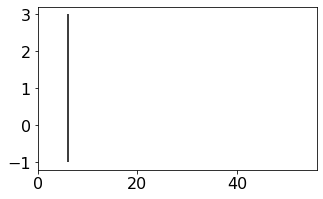

In [43]:
# verifying timepts
plt.figure(1,figsize=(5,3))
s=143
movie_ind = 0
plt.vlines(vid_start_rel_tr[movie_ind],-1,3,color='k')
if movie_ind%5 ==0:
    timepts = np.arange(49)
else:
    timepts = np.arange(56)
plt.xlim(0,56)
lm_estimate_slopereg(tcs_run_z[s,0,timepts,movie_ind])

In [48]:
def linReg(dat,fileName,regType):
    coef_ = np.empty((dat.shape[0],dat.shape[1])) # variable to store the regression coeffts or beta estimates for each subject and row
    start = time.time()
    parallelize=1
    if __name__ == '__main__':
        pool = Pool(processes=cpu_count()) # helps to parallelize processing

    print('movie_ind:',movie_ind)
    for s in range(dat.shape[0]): # number of subjects
        # print(s)
        if s%200 == 0:
            now = time.time()
            print(f'sub:{s}, time elapsed:{(now - start)/60:.2f}mins')
        tcs = [y for y in dat[s,:,:]] # list of length nnodes (268), each element of the list is a [32,] timcourse array
        if regType == 'block':
            coef_[s,:] = pool.map(lm_estimate_blockreg,tcs) # estimate returned as a list of size 268
        elif regType == 'slope':
            if parallelize:
                coef_[s,:] = pool.map(lm_estimate_slopereg,tcs) # estimate returned as a list of size 268
            else:
                for n in range(268):
                    coef_[s,n] = lm_estimate_slopereg(tcs[n]) # estimate returned as a list of size 268
        
    now = time.time()
    print(f'Done.total time:{(now-start)/60:.2f}mins')
    np.save(fileName,coef_)
    return coef_

- estimating trial wise regressors to do an all movies social > unsure > nonsocial analysis in 2B_2_ fmri....soc_v_unsure_v_nonsocial.ipynb

## Estimating regression coeffts

### For within-movie analyses- movie (RAND, FISH etc)

In [47]:
for movie_ind in range(10):
    print(timepts_indiv_movie[movie_ind].shape[0])

49
56
56
56
56
49
56
56
56
56


In [49]:
# Slope regressor, run norm (bill,fishing, rand, , tennis (since drifting looked weird))
movie_inds = list(np.arange(10))
reg_slope = reg_slope.reshape((-1, 1))
coef_slopereg_runnorm= np.empty((tcs_run_z.shape[0],tcs_run_z.shape[1],len(movie_inds)))
coef_slopereg_runnorm[:] = np.nan
for i,movie_ind in enumerate(movie_inds):
    print('\nSlope','runnorm,',vid_joined[movie_ind])
    ts = np.arange(timepts_indiv_movie[movie_ind].shape[0]) # 0-49 or 0-56
    fileName = os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_{vid_joined[movie_ind]}{suff}.npy')
    coef_slopereg_runnorm[:,:,i] = linReg(tcs_run_z[: ,: , ts, movie_ind], fileName,'slope')
print('\n\nData saved on/at:',datetime.now()) # cell run at


Slope runnorm, COAXING-B
movie_ind: 0
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.08mins
sub:400, time elapsed:0.17mins
sub:600, time elapsed:0.26mins
sub:800, time elapsed:0.36mins
sub:1000, time elapsed:0.45mins
Done.total time:0.48mins

Slope runnorm, BILLIARD-A
movie_ind: 1
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.11mins
sub:400, time elapsed:0.23mins
sub:600, time elapsed:0.33mins
sub:800, time elapsed:0.44mins
sub:1000, time elapsed:0.56mins
Done.total time:0.58mins

Slope runnorm, DRIFTING-A
movie_ind: 2
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.11mins
sub:400, time elapsed:0.20mins
sub:600, time elapsed:0.29mins
sub:800, time elapsed:0.39mins
sub:1000, time elapsed:0.49mins
Done.total time:0.52mins

Slope runnorm, Fishing
movie_ind: 3
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.10mins
sub:400, time elapsed:0.20mins
sub:600, time elapsed:0.29mins
sub:800, time elapsed:0.39mins
sub:1000, time elapsed:0.48mins
Done.total time:0.50mins

Slo

### coax/bill

In [36]:
# Slope regressor, trial-norm data (coax/bill analyses)
movie_inds = [0,1]
coef_slopereg_trialnorm = np.empty((tcs_trial_z.shape[0],tcs_trial_z.shape[1],len(movie_inds)))
coef_slopereg_trialnorm[:] = np.nan
for i,movie_ind in enumerate(movie_inds):
    
    print('Slope','trial norm,' ,vid_joined[movie_ind])
    fileName = os.path.join(data_file_loc,'coefs_trial_norm','slope_reg',f'coef_slopereg_trialnorm_{vid_joined[movie_ind]}{suff}.npy')
    print(fileName)
    
    ts = np.arange(timepts_indiv_movie[movie_ind].shape[0]) # 0-49 or 0-56
    coef_slopereg_trialnorm[:,:,i] = linReg(tcs_trial_z[:,:,ts,movie_ind],fileName,'slope')

Slope trial norm, COAXING-B
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coefs_trial_norm/slope_reg/coef_slopereg_trialnorm_COAXING-B_corrected.npy
movie_ind: 0
sub:0, time elapsed:0.00mins
nan:nan:nan:nan:nan:nan:nan:nan:        4949494949494949







nan:nan:nan:nan:nan:nan:nan:nan:        4949494949494949







nan:nan:nan:nan:nan:nan:nan:nan:        4949494949494949







nan:nan:nan:nan:nan:nan:nan:nan:        4949494949494949







nan:nan:nan:nan:nan:nan:nan:nan:        4949494949494949







nan:nan:nan:nan:  nan:nan:  4949 4949

49

nan:nan:nan:
  nan:  nan:49494949
 


49nan:nan:nan:
 nan:  nan: 494949 49



49nan:nan:nan:nan:
   4949 nan:49

 
49nan:49nan:nan:
  
 nan:494949nan: 


 nan:49nan:nan:49
   49nan:
49
49 nan:
nan:49
  nan:
nan:49 49nan: 

49 nan:nan:49
  
49nan:nan:4949
 
nan:
 nan:49 49nan: 

49 49nan:49
nan: 
49
nan:nan:  nan:
  49nan: 4949
 49
nan:
nan:nan:  49 

4949nan:49nan:
nan:
nan:nan: 49nan: 
 49  49
 49

nan:49
n

In [70]:
coef_slopereg_runnorm.shape

(1049, 268, 10)

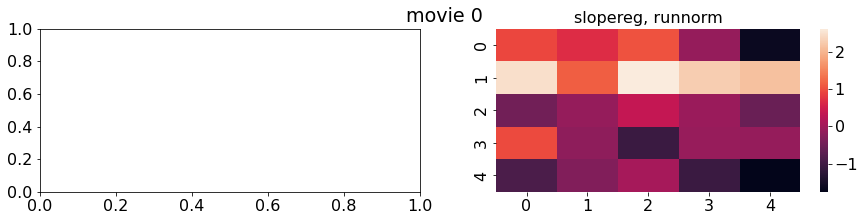

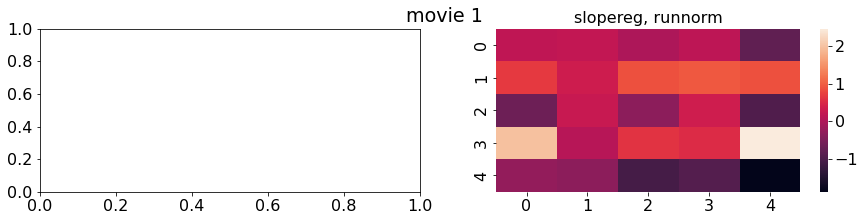

In [69]:
# sanity check: exploring results by plotting heatmaps for each movie (for a couple of subs and nodes)
for i,movie_ind in enumerate(movie_inds):
    plt.figure(i+1,figsize=(15,3))
    plt.suptitle(f'movie {movie_ind}')
    plt.subplot(121)
    plt.subplot(122)
    plt.title('slopereg, runnorm')
    sns.heatmap(coef_slopereg_runnorm[:5,:5,i])  

looks okay so far